In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import poisson
from scipy.stats import genpareto

In [2]:
fonden = pd.read_excel("data/FONDEN.xlsx")
fonden.dropna(axis=0, subset=["Estado"], inplace=True)
fonden["Estado"] = fonden.Estado.apply(lambda est: est.rstrip())

Análisis de la gravedad del siniestro de inundación por viviendas considerando año y estado.

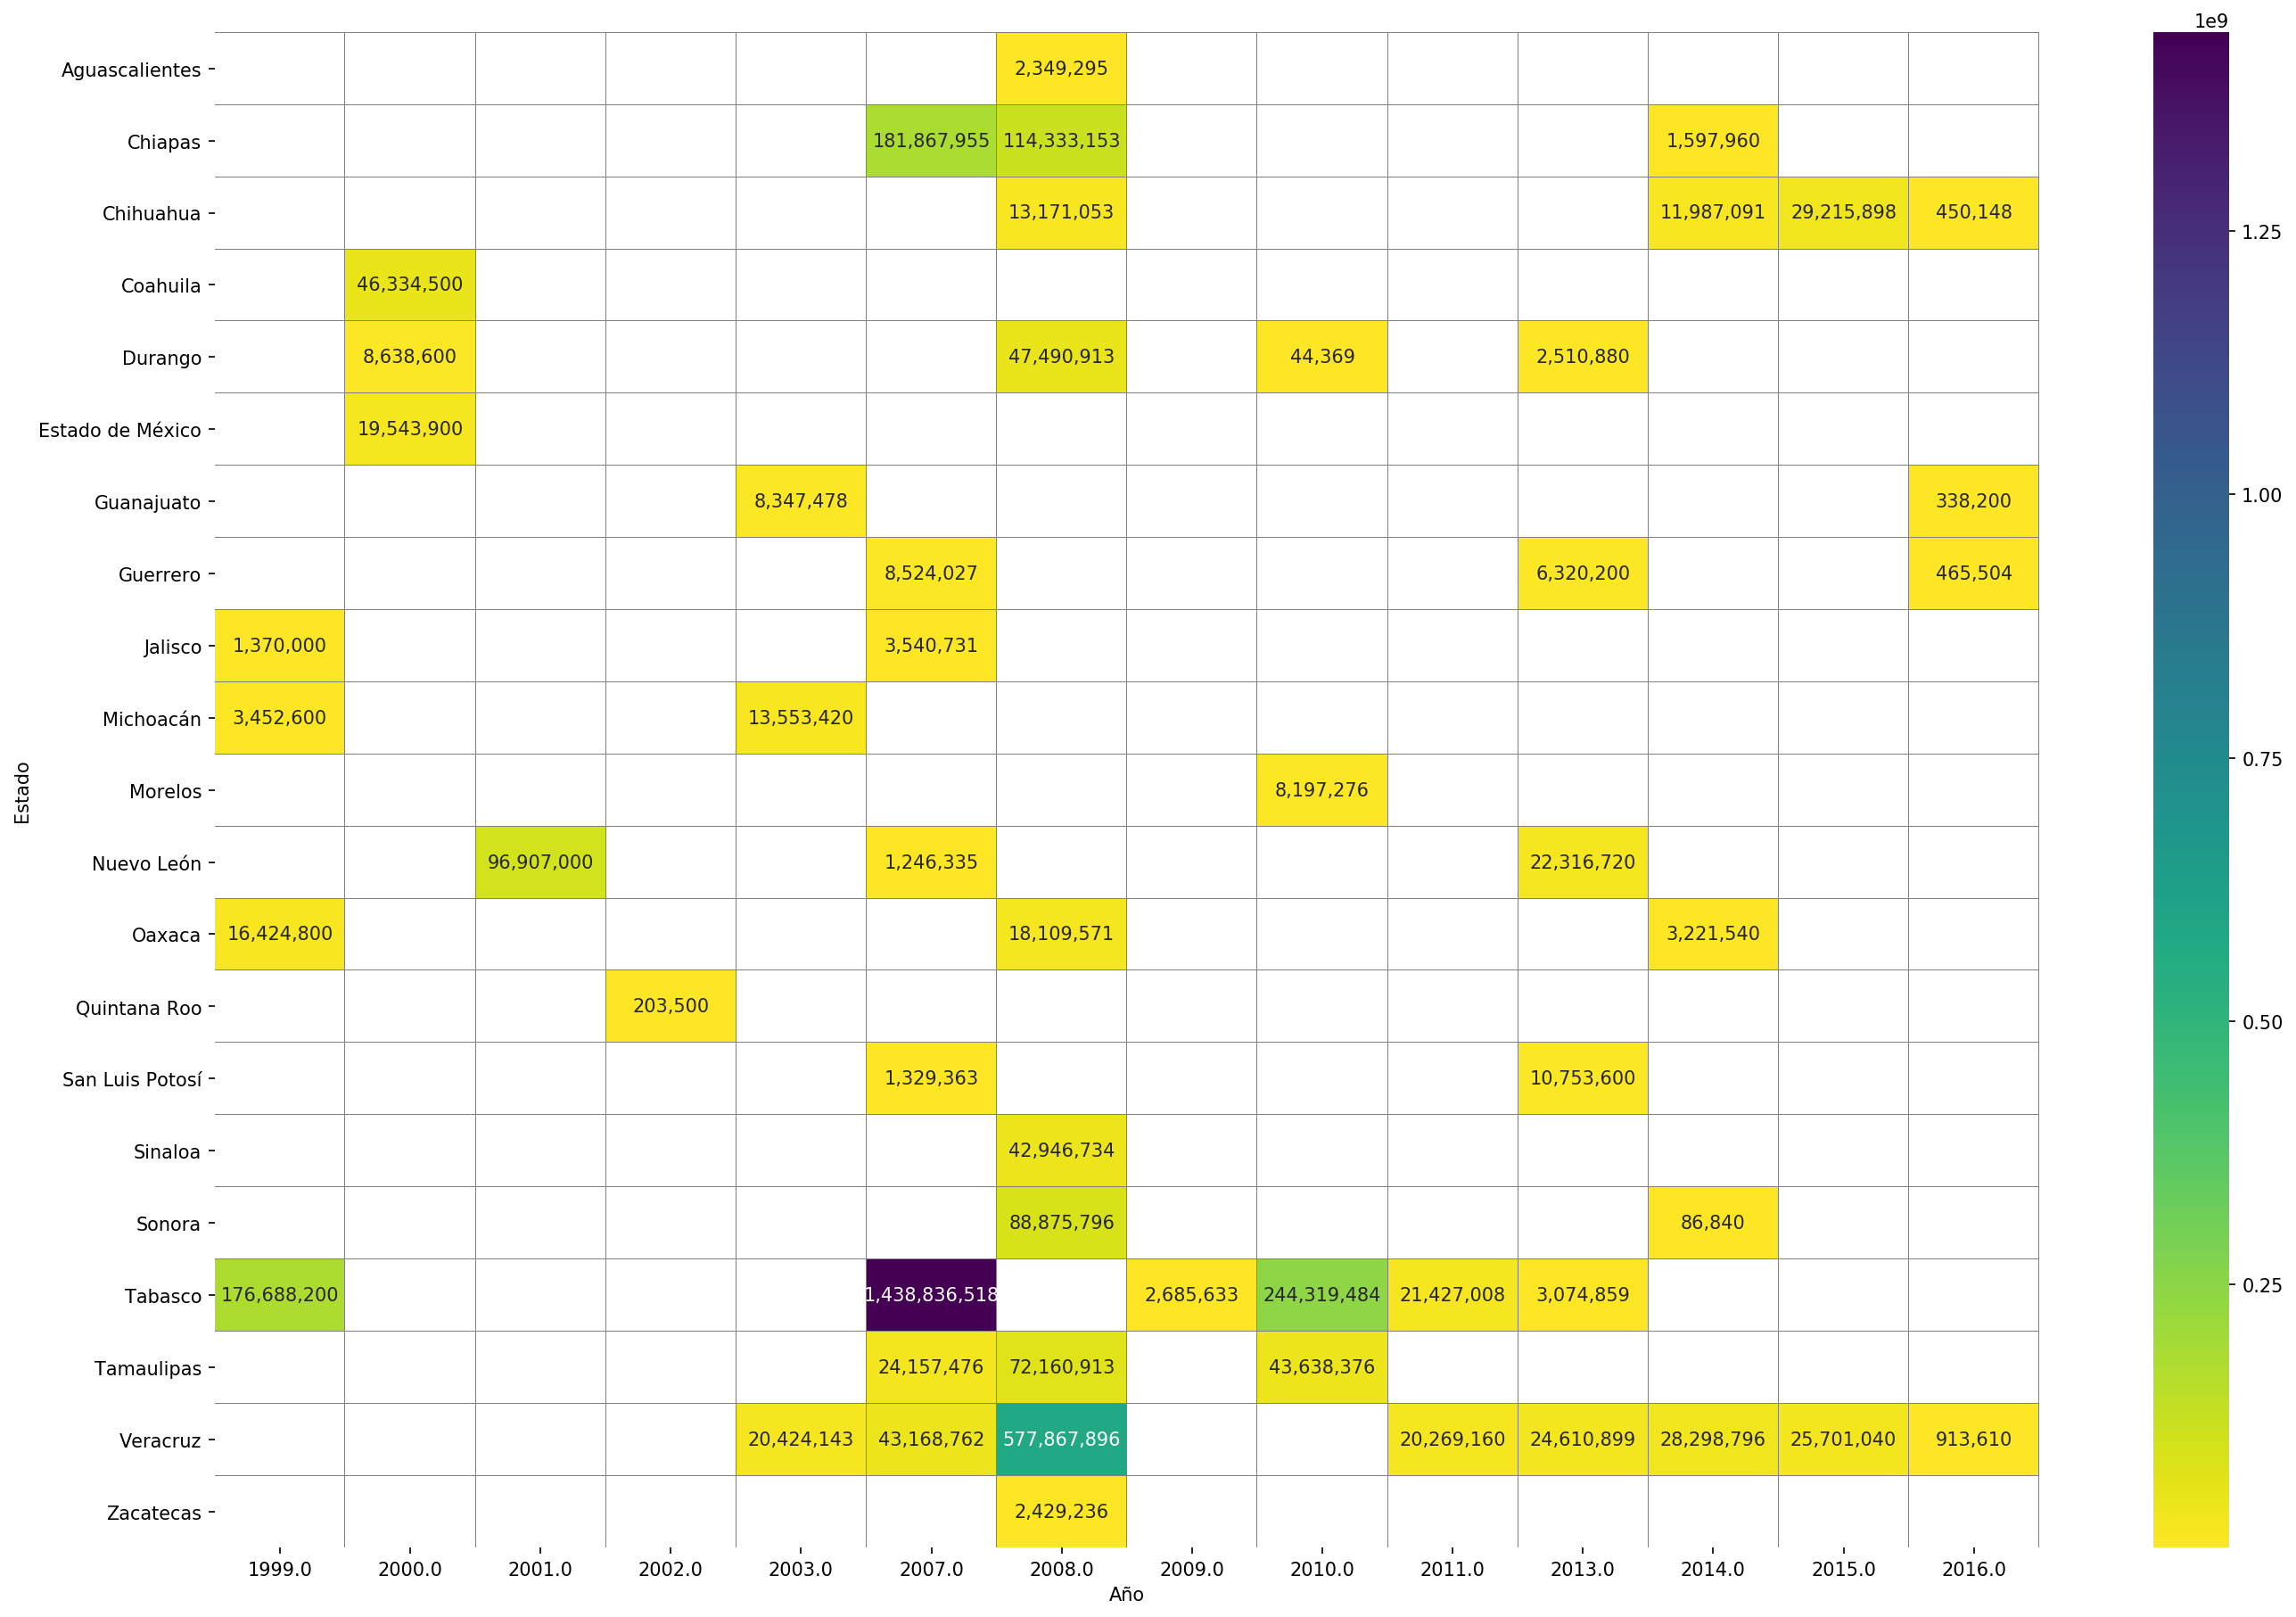

In [12]:
pt_fonden = fonden.pivot_table(values="Aportación TOTAL", columns="Año", index="Estado", aggfunc="sum")
plt.figure(figsize=(22,15), dpi=150)
sns.heatmap(pt_fonden, cmap="viridis_r", annot=True, linewidths=0.005, linecolor="gray", fmt=",.0f", cbar=True)
plt.show()

Graficamos la distribución de los siniestros, notámos que el *outlier* de la distribución lo lleva el estado de tabasco

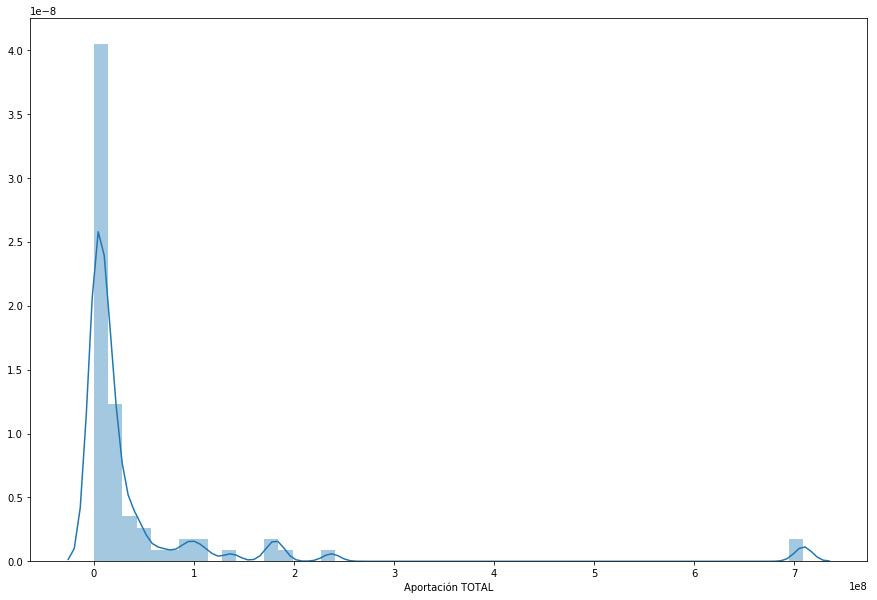

In [23]:
plt.figure(figsize=(15,10))
sns.distplot(fonden["Aportación TOTAL"])
plt.show()

In [26]:
plt.hist(fonden["Aportación TOTAL"], normed=True)

(array([  1.19842865e-08,   1.05743704e-09,   5.28718521e-10,
          1.76239507e-10,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          3.52479014e-10]),
 array([  4.43690000e+04,   7.09705774e+07,   1.41896786e+08,
          2.12822994e+08,   2.83749203e+08,   3.54675411e+08,
          4.25601619e+08,   4.96527828e+08,   5.67454036e+08,
          6.38380245e+08,   7.09306453e+08]),
 <a list of 10 Patch objects>)

Podemos notar que, si filtramos el estado de tabasco, la cola pesada se pierde.

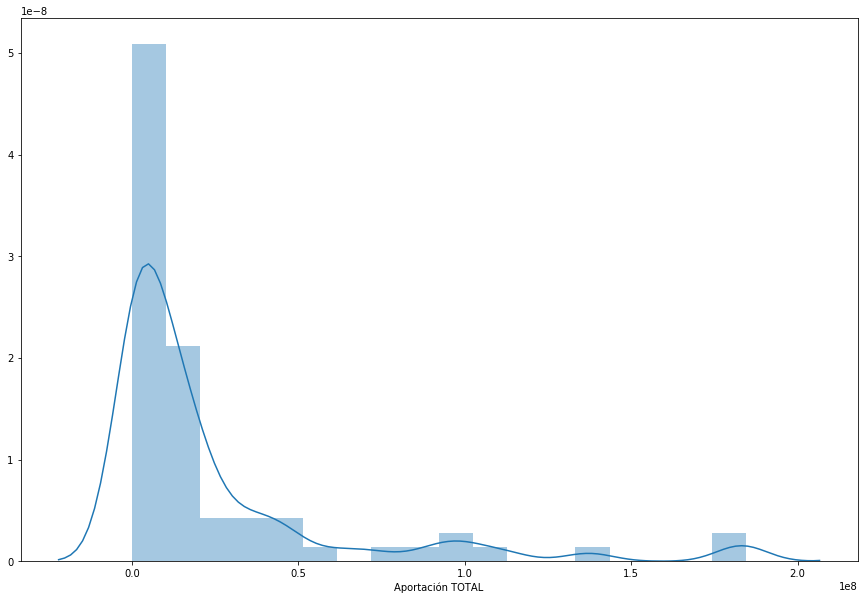

In [5]:
plt.figure(figsize=(15,10))
sns.distplot(fonden.query("Estado != 'Tabasco'")["Aportación TOTAL"])
plt.show()

### Cálculo de $\lambda$ para el número de siniestros por año

Contamos, por año, cuantos incidentes se pagaron en total. Lo gráficamos

In [6]:
fonden_count_incidentes = fonden.groupby("Año").count()["Estado"]
fonden_count_incidentes

Año
1999.0     4
2000.0     3
2001.0     2
2002.0     1
2003.0     3
2007.0    12
2008.0    16
2009.0     1
2010.0     6
2011.0     3
2013.0    10
2014.0     9
2015.0     6
2016.0     4
Name: Estado, dtype: int64

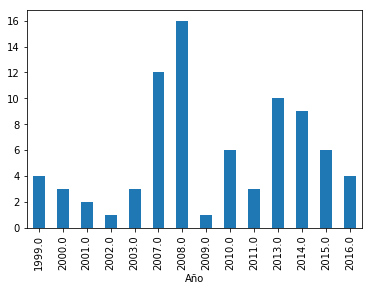

In [7]:
fonden_count_incidentes.plot(kind="bar")
plt.show()

Con el número de incidentes pagados por año, calculamos el *número promedio de siniestros* por año. Este número, será el parámetro para la distribución de los datos
Esto es, pues asumimos que el número de incidentes por año se distribuye Poisson.

In [8]:
lmbda = fonden.groupby("Año").count()["Estado"].mean()
lmbda

5.714285714285714

### Cálculo de parametros de Pareto generalizada para la *gravedad* del siniestros

Estimaremos los parametros de la pareto generalizada considerando la función de densidad:

$$
    F_X(x; \mu, \sigma, \epsilon) = 1 - \left(1 + \frac{\epsilon(x - \mu)}{\sigma}\right)^{- 1 / \epsilon}
$$

Considerando que
$$
    \mathbb{E}[X] = \mu + \frac{\sigma}{1 - \epsilon},
$$
$$
    \mathbb{V}[X] = \frac{\sigma^2}{(1 - \epsilon)^2(1 - 2\epsilon)}
$$

Se puede demostrar
$$
    \mu = X^{(1)}, \text{ll primer estadístico de orden};
$$
Y, por el método de momentos,
$$
    \hat \epsilon = \frac{1}{2}\left(1 - \frac{(\bar x - \mu)^2}{S^2}\right)
$$
$$
    \hat\sigma = (\bar x - \mu)(1 - \hat \epsilon)
$$

In [59]:
fondentot = fonden["Aportación TOTAL"]
mu = np.percentile(fondentot, 0.85)
mu = fondentot.min()
xbar = fondentot.mean()
s2 = fondentot.var()
epsilon_hat = (1 - (xbar - mu) ** 2 / s2) / 2
sigma_hat = (xbar - mu) * (1 - epsilon_hat)

In [60]:
mu, epsilon_hat, sigma_hat

(44369.0, 0.42608708479163071, 25848961.934938841)

1. Asumimos que nuestros datos (El monto de siniestro) es pareto;
2. Estimamos los parámetros de la distribución pareto; y
3. Gráficamos para una comparación visual.

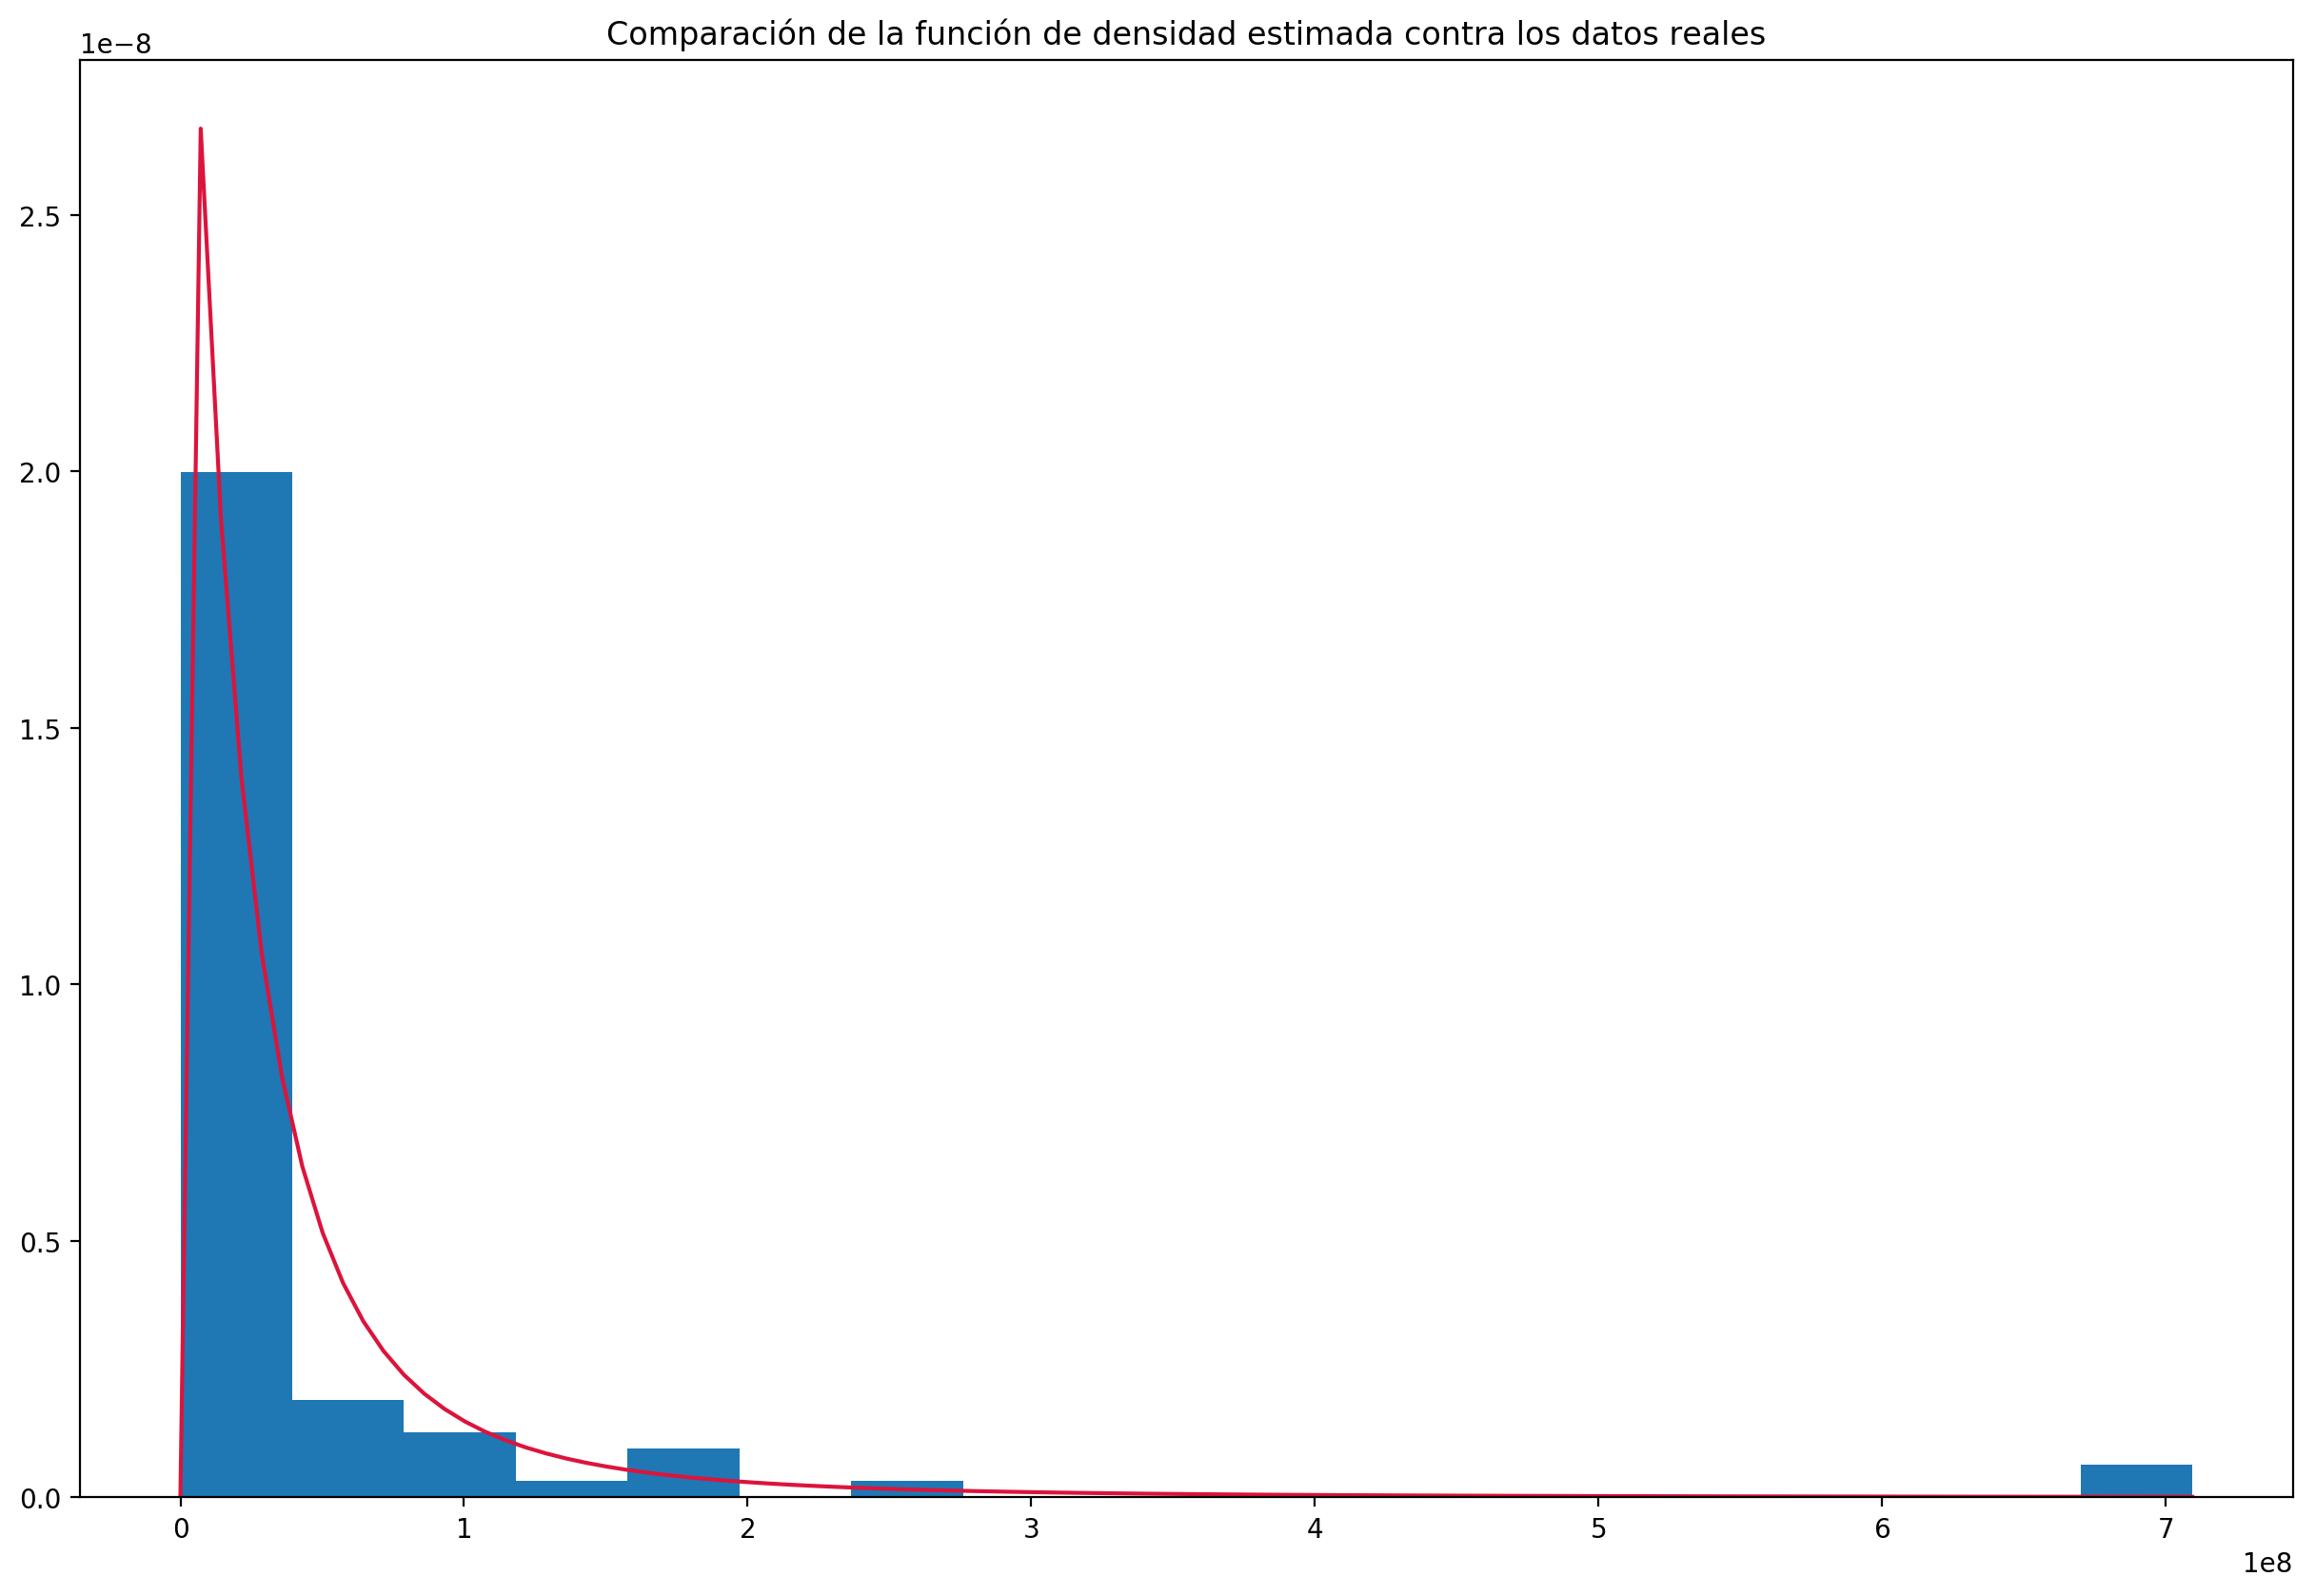

In [72]:
plt.figure(figsize=(15,10), dpi=200)
xrange = np.linspace(0, fondentot.max(), 100)
pdffonden = genpareto.pdf(xrange, epsilon_hat, mu, sigma_hat)
plt.plot(xrange, pdffonden, color="crimson")
plt.hist(fondentot,  normed=True, bins=18)
plt.title("Comparación de la función de densidad estimada contra los datos reales")
plt.show()